In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle, Arrow
import pandas
from pathlib import Path
import numpy as np
from moviepy.editor import concatenate_videoclips, VideoFileClip
from moviepy.video.fx import speedx
import os
import multiprocess as mp

import Utilities

In [3]:
csv_categorized = Utilities.GetCSVDictionary()

CP1 - 314 
CP8 - 282 
CP7 - 301 
CP3 - 309 
CP2 - 302 
CP5 - 305 
CP6 - 281 
CP4 - 3 


In [44]:
StartPosition_A=np.array([80.87,-75.15])
StartPosition_B=np.array([-85.28,78.04])
initial_Yaw_A = -89.999
initial_Yaw_B = 148.662
scenarioNumber='1'
IdealPathA = "IdealPathData/CP1_a.npz"
IdealPathB = "IdealPathData/CP1_b.npz"
CombinedRender = [   #CP1
"ISR02",
"ISR03",
"ISR05",
"ISR08",
"ISR09",
"ISR10",
"ISR12",
"ISR14",
"ISR16",
"ISR18",
"ISR19",
"ISR21",
"ISR22",
"ISR23",
"ISR24",
"ISR25",
"ISR26",
"ISR28",
"ISR29",
"ISR30",
"ISR31",
"ISR32",
"ISR33",
"ISR34",
"ISR35",
"ISR36",
"ISR37",
"ISR38",
"ISR39",
"ISR41",
"ISR42",
"NYC10",
"NYC11",
"NYC13",
"NYC16",
"NYC17",
"NYC18",
"NYC19",
"NYC20",
"NYC21",
"NYC22",
"NYC23",
"NYC24",
"NYC25",
"NYC26",
"NYC27",
"NYC28",
"NYC29",
"NYC32",
"NYC35",
"NYC36",
"NYC37",
"NYC38",
"NYC39",
"NYC40",
"NYC41",
"NYC42",
"NYC41",
"NYC42",
"NYC41",
"NYC42"
]

In [45]:
data = np.load(IdealPathA)

# List all arrays in the file
print(data['states'])

[[ -0.3228     -17.61529259   0.34242066 ...  23.06765556   0.36710951
   -1.57985495]
 [ -0.31946241 -17.478365     0.33881768 ...  22.92081778   0.35446165
   -1.58055585]
 [ -0.3161995  -17.34287721   0.34042766 ...  22.77903987   0.34935508
   -1.58106999]
 ...
 [ -3.95340917   0.42006685   0.43665663 ...  10.78831798   0.13035834
   -1.60510101]
 [ -4.08062646   0.53974476   0.42736155 ...  10.73620532   0.10749777
   -1.60603364]
 [ -4.20464899   0.65739031   0.40244837 ...  10.6932329    0.05465307
   -1.60702106]]


In [67]:
StartPosition_A=np.array([81.03,-75.33])
StartPosition_B=np.array([-87.6,88])
initial_Yaw_A = -88.328
initial_Yaw_B = 160.91
scenarioNumber='5'
CombinedRender = [#CP5
"ISR02",
"ISR05",
"ISR08",
"ISR09",
"ISR10",
"ISR11",
"ISR12",
"ISR13",
"ISR14",
"ISR16",
"ISR17",
"ISR18",
"ISR19",
"ISR21",
"ISR22",
"ISR23",
"ISR24",
"ISR25",
"ISR26",
"ISR28",
"ISR29",
"ISR30",
"ISR31",
"ISR32",
"ISR33",
"ISR34",
"ISR35",
"ISR36",
"ISR37",
"ISR41",
"ISR42",
"NYC10",
"NYC11",
"NYC12",
"NYC13",
"NYC14",
"NYC15",
"NYC16",
"NYC17",
"NYC19",
"NYC20",
"NYC21",
"NYC22",
"NYC24",
"NYC25",
"NYC26",
"NYC27",
"NYC28",
"NYC29",
"NYC32",
"NYC35",
"NYC36",
"NYC37",
"NYC38",
"NYC39",
"NYC40",
"NYC42"
]

In [68]:

renderdict={}
for scen in csv_categorized[scenarioNumber]:
    Name = scen.name
    ScenarioName = Name
    pair =Name.split('_')[1].split('-')[1]
    if(pair in CombinedRender):
        renderdict[pair] = scen
a= [x for x in renderdict.keys() if x not in CombinedRender]   
if(len(a)>0):
    print("we are missing a file",a)
else:
    print("we got all files")

    

we got all files


In [69]:
cwd = os.getcwd()
video_out = Path(cwd) / 'VideoPath'
data_out = Path(cwd) / 'ComputedData'

In [70]:
def yaw_san(val):
    # Normalize val to the range of [0, 360)
    val = val % 360
    if val > 180:
        # Adjust to (-180, 0]
        return val - 360
    return val

def r_or(vector, angle):
    """
    Rotate a 2D vector (x, z) around the origin by an angle in radians using NumPy.
    
    Parameters:
    - x: The x-coordinate of the vector or an array of x-coordinates.
    - z: The z-coordinate of the vector or an array of z-coordinates.
    - angle: The rotation angle in radians.
    
    Returns:
    - new_x: The x-coordinate of the rotated vector(s).
    - new_z: The z-coordinate of the rotated vector(s).
    """
    angle =np.deg2rad(angle)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    vectors = np.array(vector)
    rotated_vectors = np.dot(rotation_matrix, vectors)
    return rotated_vectors



In [19]:

def DrawAnimationVideo(path,name,outputPath,RenderBackground=True):
    print(f"Starting with {name}!")  
    wantedDistanceWithin = 35
    df = pandas.read_csv(path, sep=';')
    #print(df.columns)
    #return
    if('Car PositionXA' not in df.columns):
        print(pair, "Could not compute missing colum")
        return
    
    firstItemIndex = 0
    
    offset_Head_A = StartPosition_A - np.array([df['HeadPosXA'].iloc[firstItemIndex],df['HeadPosZA'].iloc[firstItemIndex]])
    temp_yaw_A = yaw_san(df['HeadrotYA'].iloc[firstItemIndex])
    offset_Yaw_A = -yaw_san(yaw_san(initial_Yaw_A) - temp_yaw_A)
    offset_Head_A = r_or(offset_Head_A,temp_yaw_A+offset_Yaw_A)

    #temp_yaw_A,offset_Yaw_A,offset_Head_A
    
    offset_Head_B = StartPosition_B - np.array([df['HeadPosXB'].iloc[firstItemIndex],df['HeadPosZB'].iloc[firstItemIndex]])
    #print(offset_Head_B,StartPosition_CP1_B,np.array([df['HeadPosXB'].iloc[0],df['HeadPosZB'].iloc[0]]))
    temp_yaw_B = yaw_san(df['HeadrotYB'].iloc[firstItemIndex])
    offset_Yaw_B = -yaw_san(yaw_san(initial_Yaw_B) - temp_yaw_B)
    offset_Head_B = r_or(offset_Head_B,temp_yaw_B+offset_Yaw_B)


    print(f"A=> is: {temp_yaw_A}\t should: {initial_Yaw_A }\t offset: {offset_Yaw_A}, ")
    print(f"B=> is: {temp_yaw_B}\t should: {initial_Yaw_B }\t offset: {offset_Yaw_B}, ")
    dfLimit = df[\
         ((df['HeadPosXA'] > -wantedDistanceWithin) & (df['HeadPosXA'] < wantedDistanceWithin)) \
            & ((df['HeadPosZA'] > -wantedDistanceWithin) & (df['HeadPosZA'] < wantedDistanceWithin))\
            & ((df['HeadPosXB'] > -wantedDistanceWithin) & (df['HeadPosXB'] < wantedDistanceWithin)) \
            & ((df['HeadPosZB'] > -wantedDistanceWithin) & (df['HeadPosZB'] < wantedDistanceWithin))]
    frameCount = len(dfLimit)
    length= dfLimit["ScenarioTime"].iloc[-1] - dfLimit["ScenarioTime"].iloc[0]
    frameTime = length/frameCount
    #print(f"FrameTime:{frameTime}, frameCount:{frameCount}, length:{length}")
    

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8, True)
    ax.set_title=name
    ax.axis('equal')
    ax.set(xlim=[-wantedDistanceWithin, wantedDistanceWithin], ylim=[-wantedDistanceWithin, wantedDistanceWithin], xlabel='x', ylabel='y')
   
    #scatA = ax.scatter(dfLimit['Car PositionXA'].iloc[0], dfLimit['Car PositionZA'].iloc[0], c="g", s=5, label=f'A')

    lineA, = ax.plot(dfLimit['HeadPosXA'].iloc[0], dfLimit['HeadPosZA'].iloc[0], color='r',label=f'A')
    lineB, = ax.plot(dfLimit['HeadPosXB'].iloc[0], dfLimit['HeadPosZB'].iloc[0], color='b',label=f'B')
    #scatB = ax.scatter(dfLimit['HeadPosXB'].iloc[0], dfLimit['HeadPosZB'].iloc[0], c="b", s=5, label=f'B')
    StartValueTime = dfLimit["ScenarioTime"].iloc[0]
    txt = ax.text(0,37,f"{name} : {-StartValueTime+dfLimit["ScenarioTime"].iloc[0]:.1f}",fontsize=14,horizontalalignment='center',verticalalignment='center')
    
    if RenderBackground:
        im = plt.imread("Background_SL.png")
        im = ax.imshow(im, extent=[-35, 35, -35,35])
    
    
    width = 1.85
    length = 4.6375
    
    yawA= yaw_san(-dfLimit['HeadrotYA'].iloc[0]+offset_Yaw_A)
    offset_Box_A = -r_or([width/2,length/2],yawA)
    offset_Head_A_tmp = r_or(offset_Head_A,yawA)
    Point_X_A = dfLimit['HeadPosXA'].iloc[0]+offset_Box_A[0]+offset_Head_A_tmp[0]
    Point_Z_A = dfLimit['HeadPosZA'].iloc[0]+offset_Box_A[1]+offset_Head_A_tmp[1]
    rectA = ax.add_patch(Rectangle((Point_X_A, Point_Z_A),width,length,angle=yawA,rotation_point='xy'))
    rectA.set_color([1,0,0,0.5])
    

    rectA_OG_yaw = dfLimit['Car RotationYA'].iloc[0]
    offset_Box_A_OG = -r_or([width/2,length/2],rectA_OG_yaw)
    rectA_OG = ax.add_patch(Rectangle(offset_Box_A_OG+(dfLimit['Car PositionXA'].iloc[0], dfLimit['Car PositionZA'].iloc[0]),width,length,angle=rectA_OG_yaw,rotation_point='xy'))
    rectA_OG.set_color([0.8,0.8,0,0.25])



    fwd=np.array([0,2])
    fwd_tmp = r_or(fwd,yawA)
    #arrowA = ax.add_patch(Arrow(Point_X_A, Point_Z_A, fwd_tmp[0], fwd_tmp[1],  head_width=0.1, head_length=0.1, fc='r', ec='r'))
    

    yawB=yaw_san(-dfLimit['HeadrotYB'].iloc[0]+offset_Yaw_B)
    offset_Box_B = -r_or([width/2,length/2],yawB)
    offset_Head_B_tmp = r_or(offset_Head_B,yawB)
    Point_X_B = dfLimit['HeadPosXB'].iloc[0]+offset_Box_B[0]+offset_Head_B_tmp[0]
    Point_Z_B = dfLimit['HeadPosZB'].iloc[0]+offset_Box_B[1]+offset_Head_B_tmp[1]
    #print(f"X: {dfLimit['HeadPosXB'].iloc[0]}   {offset_Box_B[0]}  {offset_Head_B_tmp[0]}")

    #print(f"Z: {dfLimit['HeadPosZB'].iloc[0]}   {offset_Box_B[1]}  {offset_Head_B_tmp[1]}")
    rectB = ax.add_patch(Rectangle((Point_X_B,Point_Z_B),width,length,angle=yawB,rotation_point='xy'))
    rectB.set_color([0,0,1,0.5])
    
    ax.legend()
    def update(frame):
        # update the scatter plot:
        
        lineA.set_data(dfLimit['HeadPosXA'].iloc[:frame], dfLimit['HeadPosZA'].iloc[:frame])
        lineB.set_data(dfLimit['HeadPosXB'].iloc[:frame], dfLimit['HeadPosZB'].iloc[:frame])





        txt.set_text(f"{name} : {-StartValueTime+dfLimit["ScenarioTime"].iloc[frame]:.1f}")

        
        dataA = np.stack([dfLimit['HeadPosXA'].iloc[frame], dfLimit['HeadPosZA'].iloc[frame]]).T
        yawA=yaw_san(-dfLimit['HeadrotYA'].iloc[frame]+offset_Yaw_A)
        offset_Box_A = -r_or([width/2,length/2],yawA)
        offset_Head_A_tmp = r_or(offset_Head_A,yawA)


        #datatest = np.stack([dfLimit['Car PositionXA'].iloc[frame], dfLimit['Car PositionZA'].iloc[frame]]).T
        #scatA.set_offsets(datatest)

        fwd_tmp = r_or(fwd,yawA)
        #arrowA.set_xy(dataA) #= ax.arrow(dataA[0], dataA[1], offset_Head_A_tmp[0]*10, offset_Head_A_tmp[1]*10,  head_width=0.1, head_length=0.1, fc='r', ec='r')
    
        rectA.set_xy(dataA+offset_Box_A+offset_Head_A_tmp)
        rectA.set_angle(yawA)


        rectA_OG_yaw = -dfLimit['Car RotationYA'].iloc[frame]
        offset_Box_A_OG = -r_or([width/2,length/2],rectA_OG_yaw)
        dataA_OG = np.stack([dfLimit['Car PositionXA'].iloc[frame], dfLimit['Car PositionZA'].iloc[frame]]).T
        rectA_OG.set_xy(dataA_OG+offset_Box_A_OG)
        rectA_OG.set_angle(rectA_OG_yaw)

        dataB = np.stack([dfLimit['HeadPosXB'].iloc[frame], dfLimit['HeadPosZB'].iloc[frame]]).T
        yawB=yaw_san(-dfLimit['HeadrotYB'].iloc[frame]+offset_Yaw_B)
        offset_Box_B = -r_or([width/2,length/2],yawB)
        offset_Head_B_tmp = r_or(offset_Head_B,yawB)
        rectB.set_xy(dataB+offset_Box_B+offset_Head_B_tmp)
        rectB.set_angle(yawB)


        return (lineA,lineB,txt,rectA,rectB )#,arrowA)#,scatA)

    ani = animation.FuncAnimation(fig=fig, func=update, frames=frameCount, interval=1000*frameTime)
    ani.save(filename=outputPath, writer="ffmpeg",dpi=100)
    print(f"Finished {name}!")  

def DrawAnimationVideo_Unpack(data):
    return DrawAnimationVideo(data[0],data[1],data[2],data[3])


In [20]:
testScene = "NYC39"
test = DrawAnimationVideo(renderdict[testScene],"testScene",video_out / f"scenario{scenarioNumber}-{testScene}_testScene.mp4",True)

Starting with testScene!


In [ ]:
ToDoList=[]
for pair in renderdict:
    tmp = f"ScenarioCP{scenarioNumber}-{pair}.mp4"
    ToDoList.append([renderdict[pair],tmp,video_out / tmp,False])

with mp.Pool(10) as p:
    print("starting work")
    result = p.map(DrawAnimationVideo_Unpack, ToDoList)

In [71]:

def ReCompute(path,name,outpath):
    #print(f"Starting with {name}!")  
    wantedDistanceWithin = 35
    df = pandas.read_csv(path, sep=';')
    #print(df.columns)
    if('Car PositionXA' not in df.columns):
        print(pair, "Could not compute missing colum")
        return
    
    
    offset_Head_A = StartPosition_A - np.array([df['HeadPosXA'].iloc[0],df['HeadPosZA'].iloc[0]])
    temp_yaw_A = yaw_san(df['HeadrotYA'].iloc[0])
    offset_Yaw_A = -yaw_san(yaw_san(initial_Yaw_A) - temp_yaw_A)
    offset_Head_A = r_or(offset_Head_A,temp_yaw_A+offset_Yaw_A)

    
    offset_Head_B = StartPosition_B - np.array([df['HeadPosXB'].iloc[0],df['HeadPosZB'].iloc[0]])
    temp_yaw_B = yaw_san(df['HeadrotYB'].iloc[0])
    offset_Yaw_B = -yaw_san(yaw_san(initial_Yaw_B) - temp_yaw_B)
    offset_Head_B = r_or(offset_Head_B,temp_yaw_B+offset_Yaw_B)
    
    def transform_row(row):
        # Compute the yaw after normalization and adjustment
        yawA = yaw_san(-row['HeadrotYA'] + offset_Yaw_A)
        offset_Head_A_tmp = r_or(offset_Head_A, yawA)
        Point_X_A = row['HeadPosXA'] + offset_Head_A_tmp[0]
        Point_Z_A = row['HeadPosZA'] + offset_Head_A_tmp[1]

        yawB = yaw_san(-row['HeadrotYB'] + offset_Yaw_B)
        offset_Head_B_tmp = r_or(offset_Head_B, yawA)
        Point_X_B = row['HeadPosXB'] + offset_Head_B_tmp[0]
        Point_Z_B = row['HeadPosZB'] + offset_Head_B_tmp[1]



        return pandas.Series([Point_X_A, Point_Z_A,yawA,Point_X_B,Point_Z_B,yawB])
    dfOut= pandas.DataFrame()
    dfOut[['X_A', 'Z_A','yaw_A','X_B', 'Z_B','yaw_B']]  = df.apply(transform_row, axis=1)
    dfOut['AccelA']= df['AccelA']
    dfOut['AccelB']= df['AccelB']
    dfOut['SteerA']= df['SteerA']
    dfOut['SteerB']= df['SteerB']
    dfOut.to_pickle(outpath)
    
def ReCompute_Unpack(data):
    data = ReCompute(data[0],data[1],data[2])
    return data[1]

In [62]:
testScene = "NYC35"
test = ReCompute(renderdict[testScene],"testScene","./test.pikle")

In [63]:
test.columns

AttributeError: 'NoneType' object has no attribute 'columns'

In [72]:
for pair in renderdict:
    print(pair)
    tmp = f"ScenarioCP{scenarioNumber}-{pair}.pkl"
    path = data_out / tmp
    ReCompute(renderdict[pair],tmp,path)


NYC22
NYC25
NYC13
NYC14
ISR25
NYC40
ISR22
ISR14
ISR13
NYC15
NYC12
NYC24
ISR41
ISR12
ISR23
ISR24
ISR08
ISR37
ISR30
NYC39
NYC37
ISR31
ISR09
ISR36
NYC36
NYC38
ISR21
ISR26
ISR19
ISR10
ISR17
ISR28
NYC26
NYC19
NYC21
NYC17
NYC28
NYC10
ISR16
ISR29
ISR11
NYC42
ISR18
NYC11
NYC16
NYC29
NYC20
NYC27
ISR42
ISR02
ISR05
ISR33
ISR34
NYC32
NYC35
ISR35
ISR32


In [73]:
print("done")

done


In [41]:
values = [(j[0],j[1]) for j in result if j != None]

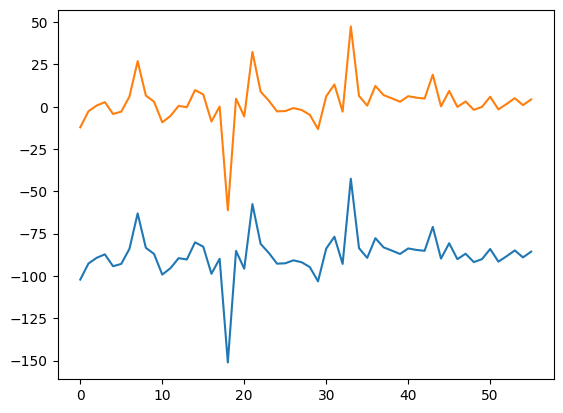

In [43]:
plt.plot(values)

In [11]:
# Specify the directory containing the video files
output_path = 'completeVideoh264.mp4'

# Retrieve all video file paths and sort them by creation date
video_files = [os.path.join(video_out, f) for f in os.listdir(video_out) if f.endswith(('.mp4', '.avi'))]
video_files.sort(key=os.path.getctime)  # Change to os.path.basename for sorting by name

# Create a list of VideoFileClip objects
clips = [VideoFileClip(f) for f in video_files]

# Concatenate the video clips
final_clip = concatenate_videoclips(clips)

# Write the result to the file system
#final_clip.write_videofile(os.path.join(video_out , output_path),codec='libx264', audio=False)

speed_up_clip = final_clip.speedx( 10)
speed_up_clip.write_videofile(os.path.join(video_out , ("speedUp"+output_path)), codec='libx264', audio=False)


# Free up resources
final_clip.close()
for clip in clips:
    clip.close()


t:  67%|██████▋   | 5651/8472 [15:14<00:39, 72.31it/s, now=None]

Moviepy - Building video /Users/dg/GitRepos/CrossCulturalDataAnalysis/VideoPath/speedUpcompleteVideoh264.mp4.
Moviepy - Writing video /Users/dg/GitRepos/CrossCulturalDataAnalysis/VideoPath/speedUpcompleteVideoh264.mp4



t:  67%|██████▋   | 5651/8472 [20:49<00:39, 72.31it/s, now=None]

Moviepy - Done !
Moviepy - video ready /Users/dg/GitRepos/CrossCulturalDataAnalysis/VideoPath/speedUpcompleteVideoh264.mp4


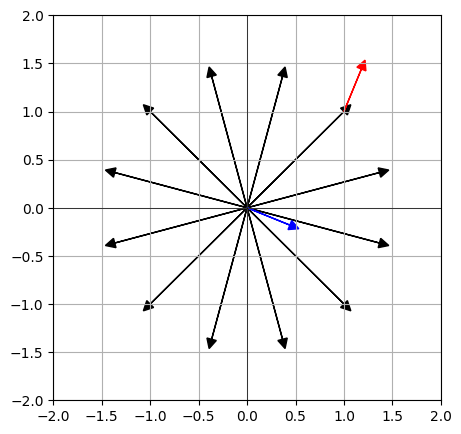

In [ ]:
# Initial forward vector pointing "up"
forward_vector = np.array([1, 1])

# Number of arrows
num_arrows = 12

# Prepare the plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# Angle between each arrow
angle_increment = 360 / num_arrows

for i in range(num_arrows):
    angle = i * angle_increment
    # Rotate the forward vector
    x, z = r_or(forward_vector, angle)
    # Draw the arrow
    ax.arrow(0, 0, x, z, head_width=0.1, head_length=0.1, fc='k', ec='k')


ax.arrow(1, 1, 0.1799, 0.4413,  head_width=0.1, head_length=0.1, fc='r', ec='r')
ax.arrow(0, 0, 0.4412852, -0.1799362,  head_width=0.1, head_length=0.1, fc='b', ec='b')

# Display the plot
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()


In [ ]:
outval = []
for pair in renderdict:
   
    df = pandas.read_csv(renderdict[pair], sep=';')
    if('Car PositionXA' not in df.columns):
        print(pair, "Could not compute missing colum")
        continue
    x_A_Offset= df['Car PositionXA'].iloc[0]-df['HeadPosXA'].iloc[0]  
    z_A_Offset= df['Car PositionZA'].iloc[0]-df['HeadPosZA'].iloc[0]  
    outval.append([x_A_Offset,z_A_Offset])
outval  = np.array(outval)

NYC42 Could not compute missing colum
